In [12]:
# import torch
# from torchvision import models, transforms
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np

# # Check if GPU is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load ResNet50
# resnet = models.resnet50(pretrained=True).eval()

# # Modify ResNet50 for style transfer
# class ResNet50ForStyleTransfer(torch.nn.Module):
#     def __init__(self):
#         super(ResNet50ForStyleTransfer, self).__init__()
#         self.selected_layers = ['layer1', 'layer2', 'layer3', 'layer4']
#         self.resnet_layers = torch.nn.Sequential(*list(resnet.children())[:8])  # Extracting the first 8 layers

#     def forward(self, x):
#         features = {}
#         for name, layer in self.resnet_layers._modules.items():
#             x = layer(x)
#             if name in self.selected_layers:
#                 features[name] = x
#         return features

# # Function to load and transform image
# def load_image(img_path, max_size=400, shape=None):
#     image = Image.open(img_path).convert('RGB')

#     if max(image.size) > max_size:
#         size = max_size
#     else:
#         size = max(image.size)

#     if shape is not None:
#         size = shape

   

# # Load images (Replace with your image paths)
# content = load_image('/kaggle/input/image/WhatsApp Image 2023-11-26 at 10.34.11 PM.jpeg').to(device)
# style = load_image('/kaggle/input/best-artworks-of-all-time/images/images/Jan_van_Eyck/Jan_van_Eyck_11.jpg', shape=content.shape[-2:]).to(device)



Total Loss:  20383322.0
Total Loss:  9037696.0
Total Loss:  5336640.0
Total Loss:  3836738.25
Total Loss:  3084517.75
Total Loss:  2608699.5
Total Loss:  2263145.5
Total Loss:  1994534.875
Total Loss:  1778099.5
Total Loss:  1598924.625
Total Loss:  1447528.125
Total Loss:  1317609.625
Total Loss:  1204672.375
Total Loss:  1105611.875
Total Loss:  1017908.375
Total Loss:  939794.4375
Total Loss:  869357.875
Total Loss:  805451.875
Total Loss:  747233.375
Total Loss:  694273.75
Total Loss:  645686.25
Total Loss:  601187.0
Total Loss:  560202.0
Total Loss:  522416.09375
Total Loss:  487475.8125
Total Loss:  454997.71875
Total Loss:  424806.25
Total Loss:  396744.3125
Total Loss:  370657.3125
Total Loss:  346480.0


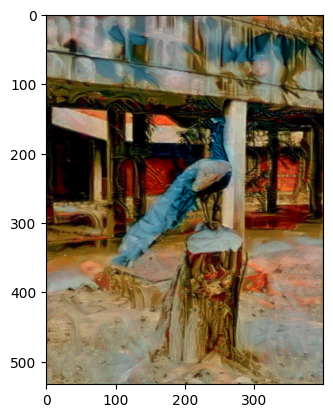

In [19]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load and transform an image
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    image = in_transform(image)[:3, :, :].unsqueeze(0)
    
    return image.to(device)

# Function to convert a tensor to an image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

# Load VGG16
vgg16 = models.vgg16(pretrained=True).features

# Freeze all VGG parameters since we're only interested in features
for param in vgg16.parameters():
    param.requires_grad_(False)

vgg16.to(device)

# Function to get features from an image
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # Content extraction
                  '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

# Function to calculate the gram matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram

# Load content and style images (Replace with your own image paths)
content = load_image("/kaggle/input/image/WhatsApp Image 2023-11-26 at 10.34.11 PM.jpeg").to(device)
style = load_image("/kaggle/input/best-artworks-of-all-time/images/images/Jan_van_Eyck/Jan_van_Eyck_11.jpg", shape=content.shape[-2:]).to(device)

# Extract features
content_features = get_features(content, vgg16)
style_features = get_features(style, vgg16)

# Compute gram matrices for each style layer
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a target image and set requires_grad to True to update it
target = content.clone().requires_grad_(True).to(device)

# Style transfer parameters
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

# Optimization loop
optimizer = optim.Adam([target], lr=0.01)
steps = 3000  # The number of iterations to update your image

for i in range(1, steps+1):
    target_features = get_features(target, vgg16)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print('Total Loss: ', total_loss.item())
        plt.imshow(im_convert(target))



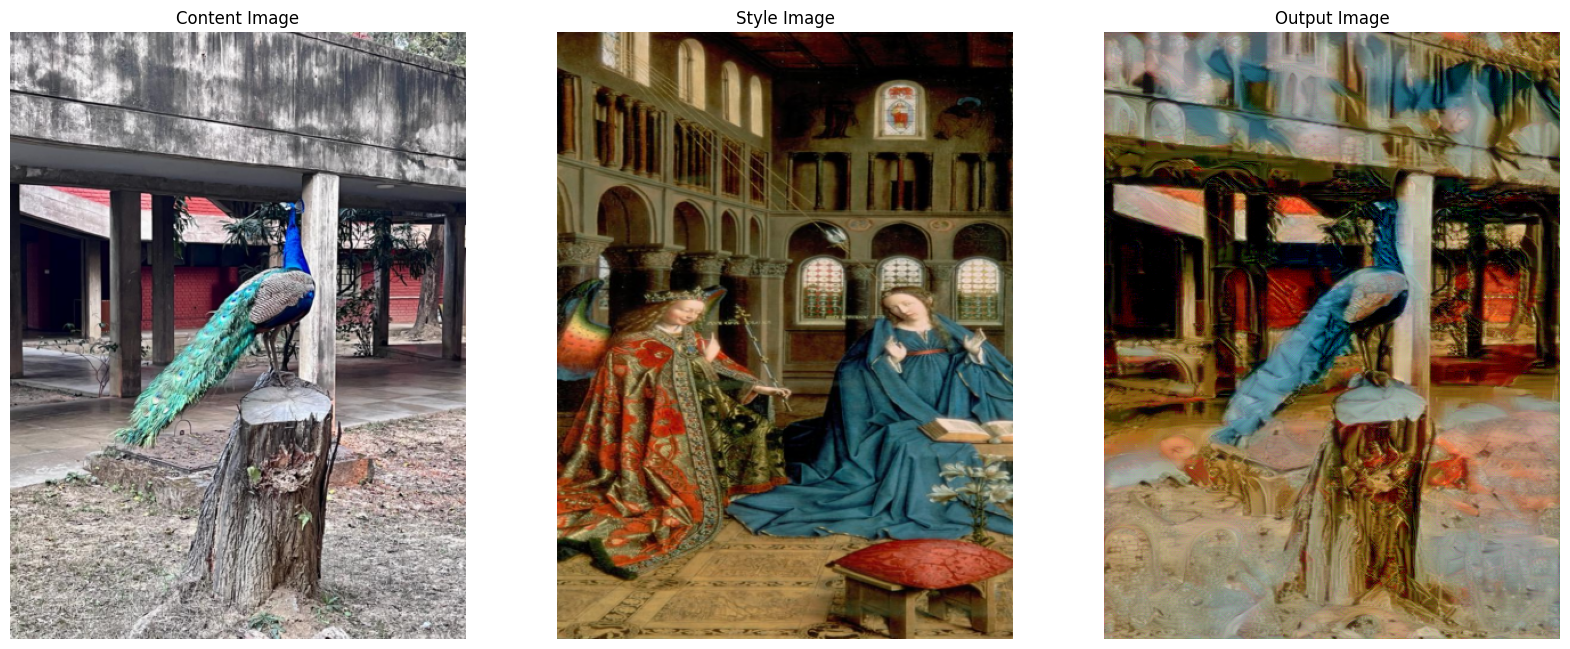

In [20]:
# Import necessary library for plotting
import matplotlib.pyplot as plt

# Display the images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
# Content image
ax1.imshow(im_convert(content))
ax1.set_title('Content Image')
ax1.axis('off')

# Style image
ax2.imshow(im_convert(style))
ax2.set_title('Style Image')
ax2.axis('off')

# Output image
ax3.imshow(im_convert(target))
ax3.set_title('Output Image')
ax3.axis('off')

plt.show()
